# Calculo de las metricas de un json

In [1]:
class Game():
    """Almacena informacion sobre una partida:
    - When the level starts and ends and its lenght
    - The event result
    - Player deaths during this level
    """
    def __init__(self, id, tsStart):
        """Constructor
        """
        self.id = id
        self.tsLevelStart = tsStart
        self.levelLengthMs = 0
        self.shields = 0    
        self.deaths = 0

    def addDeath(self):
        self.deaths += 1
    
    def addShield(self):
        self.shields += 1

    def calculateTime (self, endTime):
        self.levelLengthMs = endTime - self.tsLevelStart


### Importacion de las librerias necesarias

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Lectura del documento

In [3]:
# Ruta de los archivos con los datos obtenidos por el "Tracking system"
path = './DataTracker'

In [4]:
def loadJsonData(path):
    jsonData = []
    
    # Obtener lista de archivos en la carpeta
    jsonFiles = os.listdir(path)
    
    # Recorrer y filtrar solo los archivos JSON
    for file in jsonFiles:
        if file.endswith('.json'):
            ruta_archivo = os.path.join(path, file)
            
            # Leer el contenido del archivo JSON
            with open(ruta_archivo, 'r', encoding='utf-8') as f:
                info = json.load(f)
                jsonData.extend(info)
    
    return jsonData

In [5]:
# Leer los archivos JSON y obtener su información
data = loadJsonData(path)

# Se ordena la información del documento en base el timestamp
sorted_data = sorted(data, key=lambda x: x['timestamp'])
sorted_data

[{'id': '6e1513609ec6380eb6c8d5f796c6685ba6daf9a9087202eda36801cbd6ba1511',
  'idLevel': 0,
  'idSession': '6e1513609ec6380eb6c8d5f796c6685ba6daf9a9087202eda36801cbd6ba1511',
  'idUser': 'af25df128a73a551a6b6bc574d3f165f',
  'timestamp': 1718647428,
  'typeEvent': 'LoginEvent'},
 {'id': '5ac53c864fbd8a48b33f3aad4432f54e45c9a18bb381d5eff04b4ed5cfa9c0f5',
  'idLevel': 0,
  'idSession': '6e1513609ec6380eb6c8d5f796c6685ba6daf9a9087202eda36801cbd6ba1511',
  'idUser': 'af25df128a73a551a6b6bc574d3f165f',
  'timestamp': 1718647456,
  'typeEvent': 'StartGameEvent'},
 {'id': 'bbd6493f6293db07f60042dc39c3ee45aa6710bd4763a5ee4ab8ba92a9b0a19f',
  'idLevel': 0,
  'idSession': '6e1513609ec6380eb6c8d5f796c6685ba6daf9a9087202eda36801cbd6ba1511',
  'idUser': 'af25df128a73a551a6b6bc574d3f165f',
  'timestamp': 1718647459,
  'typeEvent': 'DeathEvent'},
 {'id': 'b44efe350053f2e3b70a8a4b740160bfaf202da3956b7b5de815c98c0e93e835',
  'idLevel': 0,
  'idSession': '6e1513609ec6380eb6c8d5f796c6685ba6daf9a9087202ed

### Duraciones de cada sesion

In [6]:
# Longitud de cada sesion en milisegundos
sessionLengthMs = []
for currentEvent in sorted_data:
    if currentEvent['typeEvent'] == "LoginEvent":
        tsSessionStart = currentEvent['timestamp']
    if currentEvent['typeEvent'] == "LogoutEvent":
        tsSessionEnd = currentEvent['timestamp']
        sessionLengthMs.append(tsSessionEnd- tsSessionStart)

s = pd.Series(sessionLengthMs)
#print(s.describe())
s

0    195
1    234
2    232
dtype: int64

### Calculo de las metricas

Las metricas a tener en cuenta son:
- Numero de muertes por partida
- Numero de veces que se pierde el escudo por nivel
- Tiempo en complentar una partida

Adicionalmete se ha añadido las muertes totales y numero de perdidas de escudo por sesion

In [7]:
game_list = []
index_game = 0
sesion = 0
# Indice de eventos
index = 0
# Numero total de eventos
num_events = len(sorted_data)
# Lista de muertes para hacer la media
death_list = []
# Lista de escudos para hacer la media
shield_list = []

level = 0
shields_per_level = 0

In [8]:
duration = []
deathCount = []

def parseEvent(event):
    global index_game
    global game_list
    global sesion
    global death_list
    global shield_list
    global level
    global shields_per_level
    if event['typeEvent'] == "LoginEvent":
        print("\nInicio de sesion: ", sesion)
    elif event['typeEvent'] == "LogoutEvent":
        shields = 0
        deaths = 0
        shields += game_list[len(game_list) - 1].shields
        deaths += game_list[len(game_list) - 1].deaths
        death_list.append(game_list[len(game_list) - 1].deaths)
        shield_list.append(game_list[len(game_list) - 1].shields)
        print("Perdidas de escudo en total: ", shields, "\nMuertes en total: ", deaths)
        print("\nFin de sesion: ", sesion)

        sesion += 1
    # Empieza la partida
    elif event['typeEvent'] == "StartGameEvent":
        game_list.append(Game(event["idLevel"], event['timestamp']))
        shields_per_level = 0
        print("\nPartida: ", index_game, )
    # Acaba la partida
    elif event['typeEvent'] == "EndGameEvent":
        tsEndTime = event['timestamp']
        game_list[index_game].calculateTime(tsEndTime)
        duration.append(game_list[index_game].levelLengthMs)

        print("  Duración: ", game_list[index_game].levelLengthMs, "\n  Muertes: ", game_list[index_game].deaths, "\n  Perdidas de escudo: ", game_list[index_game].shields)
        print("  Nivel: ", level, ", escudos perdidos: ", shields_per_level)
        level = 0
        index_game += 1
    elif event['typeEvent'] == "LoseShieldEvent":
        game_list[index_game].addShield()
        shields_per_level +=1 
    elif event['typeEvent'] == "DeathEvent":
        game_list[index_game].addDeath()
        print("  Nivel: ", level, ", escudos perdidos: ", shields_per_level)
        shields_per_level = 0
        level +=1 
    return  True

In [9]:
# Recorro todos los eventos generados
while index < num_events:
    currentEvent = sorted_data[index]
    consumeEvent = parseEvent(currentEvent)
    index += 1


Inicio de sesion:  0

Partida:  0
  Nivel:  0 , escudos perdidos:  0
  Nivel:  1 , escudos perdidos:  0
  Duración:  163 
  Muertes:  2 
  Perdidas de escudo:  1
  Nivel:  2 , escudos perdidos:  1
Perdidas de escudo en total:  1 
Muertes en total:  2

Fin de sesion:  0

Inicio de sesion:  1

Partida:  1
  Nivel:  0 , escudos perdidos:  2
  Nivel:  1 , escudos perdidos:  2
  Nivel:  2 , escudos perdidos:  1
  Duración:  221 
  Muertes:  3 
  Perdidas de escudo:  8
  Nivel:  3 , escudos perdidos:  3
Perdidas de escudo en total:  8 
Muertes en total:  3

Fin de sesion:  1

Inicio de sesion:  2

Partida:  2
  Nivel:  0 , escudos perdidos:  2
  Nivel:  1 , escudos perdidos:  1
  Nivel:  2 , escudos perdidos:  1
  Nivel:  3 , escudos perdidos:  2
  Duración:  225 
  Muertes:  4 
  Perdidas de escudo:  7
  Nivel:  4 , escudos perdidos:  1
Perdidas de escudo en total:  7 
Muertes en total:  4

Fin de sesion:  2


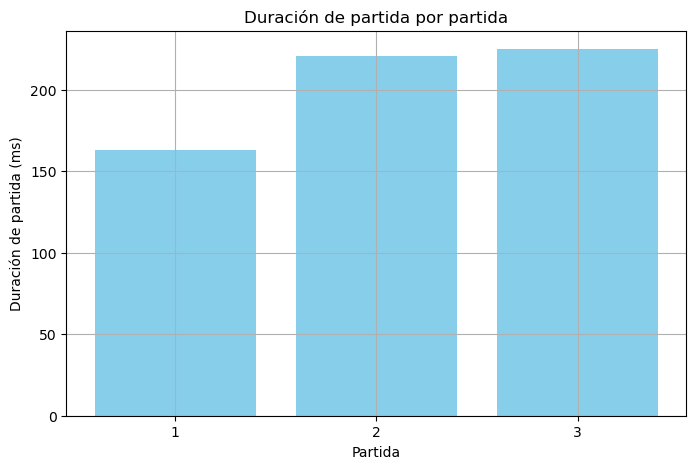

In [10]:
#Grafico de la Duración de cada partida
plt.figure(figsize=(8, 5))
plt.bar(range(len(duration)), duration, color='skyblue')
plt.xlabel('Partida')
plt.ylabel('Duración de partida (ms)')
plt.title('Duración de partida por partida')
plt.xticks(range(len(duration)), range(1, len(duration) + 1))
plt.grid(True)
plt.show()

[2, 3, 4]


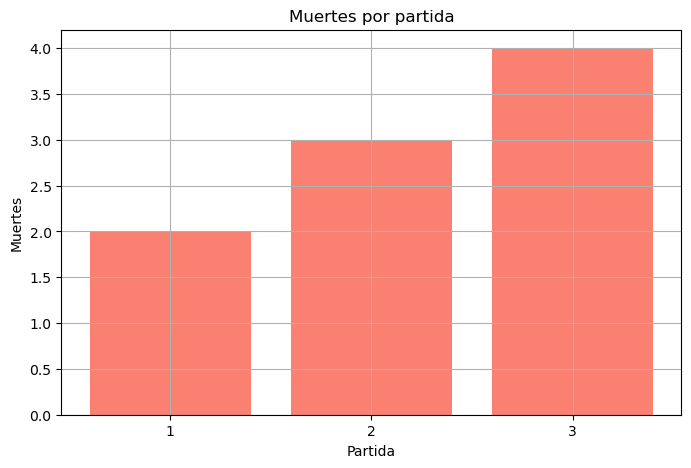

In [11]:
plt.figure(figsize=(8, 5))
plt.bar(range(len(death_list)), death_list, color='salmon')
print(death_list)
plt.xlabel('Partida')
plt.ylabel('Muertes')
plt.title('Muertes por partida')
plt.xticks(range(len(death_list)), range(1, len(death_list) + 1))
plt.grid(True)
plt.show()

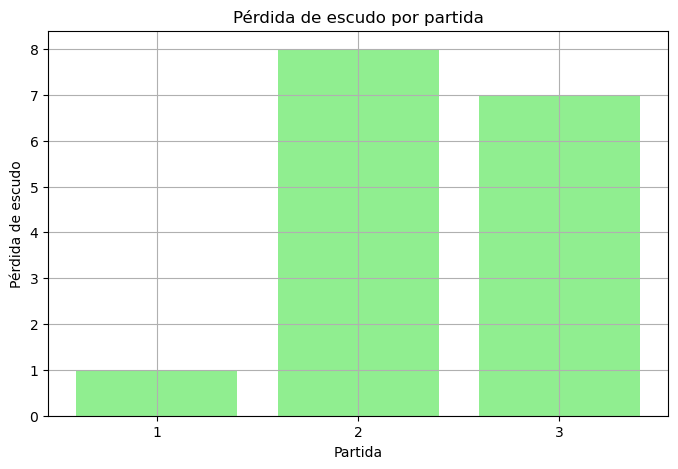

In [12]:
plt.figure(figsize=(8, 5))
plt.bar(range(len(shield_list)), shield_list, color='lightgreen')
plt.xlabel('Partida')
plt.ylabel('Pérdida de escudo')
plt.title('Pérdida de escudo por partida')
plt.xticks(range(len(shield_list)), range(1, len(shield_list) + 1))
plt.grid(True)
plt.show()

### Medias

Esto implica todas las sesiones y partidas, es la media total

In [13]:
mean = np.mean(death_list)
print("\nMedia de muertes:", round(mean, 2))
mean = np.mean(shield_list)
print("Media de perdidas de escudo:", round(mean, 2)) 
mean = np.mean(duration)
print("Media de la duracion de las partidas:", round(mean, 2))  



Media de muertes: 3.0
Media de perdidas de escudo: 5.33
Media de la duracion de las partidas: 203.0
